In [489]:
from math import sqrt
from datetime import datetime, timedelta

# for scaling and inverse_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from pandas import read_csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## 1. Read the raw csv data

In [490]:
cols=['id', 'created_at', 'destroyed_at']
server_data = pd.read_csv("servers.csv", delimiter=",", names=cols, header=None )

In [491]:
cols=['timestamp', 'device_id', 'user_id','server_id', 'connected']
dtypes = {'timestamp': 'str', 'device_id': 'int', 'user_id': 'int', 'server_id': 'int', 'connected':'bool'}
parse_dates = ['timestamp']
events_data = pd.read_csv("connectivity_events.csv", delimiter=",", names=cols, header=None,dtype=dtypes, parse_dates=parse_dates )

In [492]:
events_data.shape

(9308207, 5)

In [493]:
events_data.columns

Index(['timestamp', 'device_id', 'user_id', 'server_id', 'connected'], dtype='object')

In [494]:
events_data.dtypes

timestamp    datetime64[ns]
device_id             int64
user_id               int64
server_id             int64
connected              bool
dtype: object

## 2. Fill and process the device event stream data 

In [495]:
# start, end takes pandas.Timestamp
def fillDates(start, end):
    #print("fillDates", type(start), start, type(end),end)
    dates = list()
    for i in  range(1,(end.date() - start.date()).days):
        oneday = pd.Timedelta('%d days'%i)
        dates.append(start + oneday)
    return dates

In [496]:
def processEventStream(row):
    r = list()
    dates = list()
    #print(row)

    try:
        if (device_state[row[1]]):
            #print("device details exist")
            #print(row)
            timestamp = row [0]
            device_id = row [1]
            user_id = row [2]
            server_id = row [3]
            next_event = row [4]
            
            if device_state[row[1]]["state"]: # current event 'online'
                if next_event: # next event 'online'
                    if device_state[row[1]]["server"] == server_id: # case 1
                        # Assume device was online from current event's timestamp until next event's timestamp
                        dates = fillDates(device_state[row[1]]["timestamp"], timestamp)
                    else: # case 2 different server
                        # get previous server destruction time
                        destruction_time = pd.Timestamp(server_data[server_data['id'] == 2]['destroyed_at'].values[0])
                        if (pd.Timestamp(destruction_time) < timestamp):
                            dates = fillDates(device_state[row[1]]["timestamp"], destruction_time)
                        else:
                            dates = fillDates(device_state[row[1]]["timestamp"], timestamp)
                    
                    #update the state dictionary Case 1 & 2
                    state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                    device_state[device_id] = state_dict        
                else:# next event 'offline', 
                    if device_state[row[1]]["server"] == server_id: # case 3 Normal case, same next server
                        #update the state dictionary Case 3
                        state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                        device_state[device_id] = state_dict
                    else:# case 4, different next server
                        # get previous server destruction time
                        destruction_time = pd.Timestamp(server_data[server_data['id'] == 2]['destroyed_at'].values[0])
                        dates = fillDates(device_state[row[1]]["timestamp"], destruction_time)
                        # *NO* update for the state dictionary in Case 4
            else:  # current event 'offline'
                if next_event: # next event 'online' # case 5 & case 6: Normal Case
                        #update the state dictionary: case 5 & 6
                        state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                        device_state[device_id] = state_dict
                        dates = list().append(timestamp)
                else: # next event 'offline' # case 7 &  case 8
                        pass # Ignore next event
                
            if dates:
                for d in dates:
                    newentry = list()
                    newentry.append(d)
                    newentry.append(device_id)
                    newentry.append(user_id)
                    #print(newentry)
                    rows_list.append(newentry)
                #print("more dates", dates)
            
    except KeyError:
        state_dict = {"state":row[4], "server":row[3], "timestamp":row[0]}
        device_state[row[1]] = state_dict
        #print(row[1], device_state[row[1]])
        if (row[4]):
            r = row.tolist()
            #print("r",type(r))
            rows_list.append(r[0:3]) 

    return r


In [497]:
device_state = dict()
rows_list = list()
#print( device_state)
#df = small_data.apply(processEventStream, axis=1)
events_data=events_data.apply(processEventStream, axis=1)

## 3. Calculate daily number of (unique) devices connected

In [498]:
events_data_connected =  pd.DataFrame(rows_list)
events_data_connected.columns = ["timestamp", "device_id", "user_id"]

In [499]:
events_data_connected=events_data_connected.dropna()

In [500]:
events_data_connected['date'] = pd.DatetimeIndex(events_data_connected['timestamp']).date

In [501]:
unique_device_per_day = events_data_connected.drop_duplicates(["date", "device_id"],keep = "first")

In [502]:
#dev_count_perday_peruser = unique_device_per_day.groupby(['date', 'user_id']).agg({'device_id':["count"]})

In [503]:
#dev_count_perday_peruser.columns

In [504]:
#dev_count_perday_peruser

In [505]:
dev_count_perday = unique_device_per_day.groupby(['date'])['device_id'].count().reset_index(name='count')

#### Chart device count per day

In [ ]:
start = pd.Timestamp('2016-08-13')
end = start + timedelta(days=205)
days = mdates.drange(start, end,dt.timedelta(days=1))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.plot(days, inv_yhat, "-b", label='forecast') # forecast
plt.plot(days, inv_y,    "-r"   , label='actual')   # actual
plt.legend(loc="upper right")
plt.gcf().autofmt_xdate()

fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 24
fig_size[1] = 10
plt.rcParams["figure.figsize"] =  fig_size 

plt.show()

## 4. Save data as csv

In [476]:
dev_count_perday['date'] = dev_count_perday['date'].astype('datetime64[ns]')
dev_count_perday.to_csv("data.csv")

In [477]:
prediction_input_data = dev_count_perday[(dev_count_perday["date"]) > pd.Timestamp('2017-02-28')]
prediction_input_data.to_csv("prediction_input_data.csv")

In [478]:
test_data_input = dev_count_perday[ (pd.Timestamp('2016-02-28') < dev_count_perday["date"])
                                  & (pd.Timestamp('2017-02-28') > dev_count_perday["date"])]
test_data_input.to_csv("test_data_input.csv") # 365 records

## 5. Scale and prepare Timeseries sequence

In [506]:
# prepare time series data for supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	print(type(data))
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # range([start,] stop [, step])
        # DataFrame.shift(periods=1, freq=None, axis=0), returns DataFrame
		cols.append(df.shift(i)) 
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	# We are only interested in final bb after certain frames, e.g. 31st, 61st etc
	for i in range(n_out -1, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    #  concatenating along the columns (axis=1), a DataFrame is returned.
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [507]:
count = dev_count_perday['count'].to_numpy()[0:800]
test_count = dev_count_perday['count'].to_numpy()[800:]

In [508]:
# specify the number of lag days
n_input_seq = 360
n_seq_future = 1
n_features = 1

In [524]:
# ensure all data is float
count = count.astype('float32').reshape(-1, 1)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(count.reshape(-1, 1))

In [525]:
# frame as supervised learning
reframed = series_to_supervised(count, n_input_seq, n_seq_future, True)

<class 'numpy.ndarray'>


## 6. Prepare training and validation data

In [526]:
# split into train and test sets
values = reframed.values
n_train_num = int(reframed.shape[0] * 0.8)
train = values[:n_train_num, :]
val = values[n_train_num:, :]

# split into input and outputs
n_obs = n_input_seq * n_features # In future it is expected to build the model with additional features
train_X, train_y = train[:, :n_obs], train[:, n_obs:n_obs+n_features]
val_X, val_y = val[:, :n_obs], val[:, n_obs:n_obs+n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_input_seq, n_features))
val_X = val_X.reshape((val_X.shape[0], n_input_seq, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(352, 360) 352 (352, 1)
(352, 360, 1) (352, 1) (88, 360, 1) (88, 1)


In [527]:
test_count[0]

135

## 7. Prepare the ML model

In [528]:
from keras import backend as K
from keras import optimizers

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger

In [529]:
# model callbacks.

# filepath under which the weights are saveed
model_checkpoint = ModelCheckpoint(filepath='2_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='dev_count_lstm_training_log.csv',
                       separator=',',
                       append=True)
callbacks = [model_checkpoint,
             csv_logger
            ]

In [530]:
train_X

array([[[272.],
        [ 35.],
        [ 41.],
        ...,
        [ 10.],
        [ 19.],
        [ 25.]],

       [[ 35.],
        [ 41.],
        [ 30.],
        ...,
        [ 19.],
        [ 25.],
        [ 24.]],

       [[ 41.],
        [ 30.],
        [ 21.],
        ...,
        [ 25.],
        [ 24.],
        [ 16.]],

       ...,

       [[  2.],
        [  6.],
        [ 27.],
        ...,
        [ 33.],
        [ 11.],
        [ 45.]],

       [[  6.],
        [ 27.],
        [ 26.],
        ...,
        [ 11.],
        [ 45.],
        [ 96.]],

       [[ 27.],
        [ 26.],
        [ 18.],
        ...,
        [ 45.],
        [ 96.],
        [ 74.]]], dtype=float32)

In [ ]:
# design network
K.clear_session()  # Clear previous models from memory.    
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
#adam = optimizers.Adam(lr=0.01, decay=0.0001)
model.compile(loss='mean_squared_error', optimizer="adam")
#A loss function or objective function: mean_squared_error

epochs = 300
# fit network
history = model.fit(train_X, train_y, 
                    epochs=epochs, 
                    batch_size=1, 
                    validation_data=(val_X, val_y), 
                    verbose=1,
                    callbacks=callbacks,
                    shuffle=False)

Train on 352 samples, validate on 88 samples
Epoch 1/300
352/352 [==============================] - 223s 634ms/step - loss: 883.2299 - val_loss: 4869.0561

Epoch 00001: val_loss did not improve from 2556.43097
Epoch 2/300
352/352 [==============================] - 229s 649ms/step - loss: 577.2345 - val_loss: 4145.3490

Epoch 00002: val_loss did not improve from 2556.43097
Epoch 3/300
352/352 [==============================] - 229s 650ms/step - loss: 493.5771 - val_loss: 3678.7733

Epoch 00003: val_loss did not improve from 2556.43097
Epoch 4/300
352/352 [==============================] - 229s 651ms/step - loss: 481.8426 - val_loss: 3556.9405

Epoch 00004: val_loss did not improve from 2556.43097
Epoch 5/300
352/352 [==============================] - 229s 650ms/step - loss: 474.6751 - val_loss: 3441.2592

Epoch 00005: val_loss did not improve from 2556.43097
Epoch 6/300
352/352 [==============================] - 229s 650ms/step - loss: 453.6168 - val_loss: 3225.0639

Epoch 00006: val_lo

352/352 [==============================] - 232s 658ms/step - loss: 358.5927 - val_loss: 1716.2231

Epoch 00042: val_loss improved from 1749.98980 to 1716.22312, saving model to 2_epoch-42_loss-358.5927_val_loss-1716.2231.h5
Epoch 43/300
352/352 [==============================] - 229s 650ms/step - loss: 351.8234 - val_loss: 1708.3587

Epoch 00043: val_loss improved from 1716.22312 to 1708.35865, saving model to 2_epoch-43_loss-351.8234_val_loss-1708.3587.h5
Epoch 44/300
352/352 [==============================] - 232s 658ms/step - loss: 347.2411 - val_loss: 1681.8141

Epoch 00044: val_loss improved from 1708.35865 to 1681.81414, saving model to 2_epoch-44_loss-347.2411_val_loss-1681.8141.h5
Epoch 45/300
352/352 [==============================] - 231s 655ms/step - loss: 349.0597 - val_loss: 1717.4029

Epoch 00045: val_loss did not improve from 1681.81414
Epoch 46/300
352/352 [==============================] - 234s 664ms/step - loss: 352.9391 - val_loss: 1651.5965

Epoch 00046: val_loss im

352/352 [==============================] - 230s 655ms/step - loss: 330.0292 - val_loss: 1620.8333

Epoch 00086: val_loss did not improve from 1409.13703
Epoch 87/300
335/352 [===========================>..] - ETA: 10s - loss: 281.7135

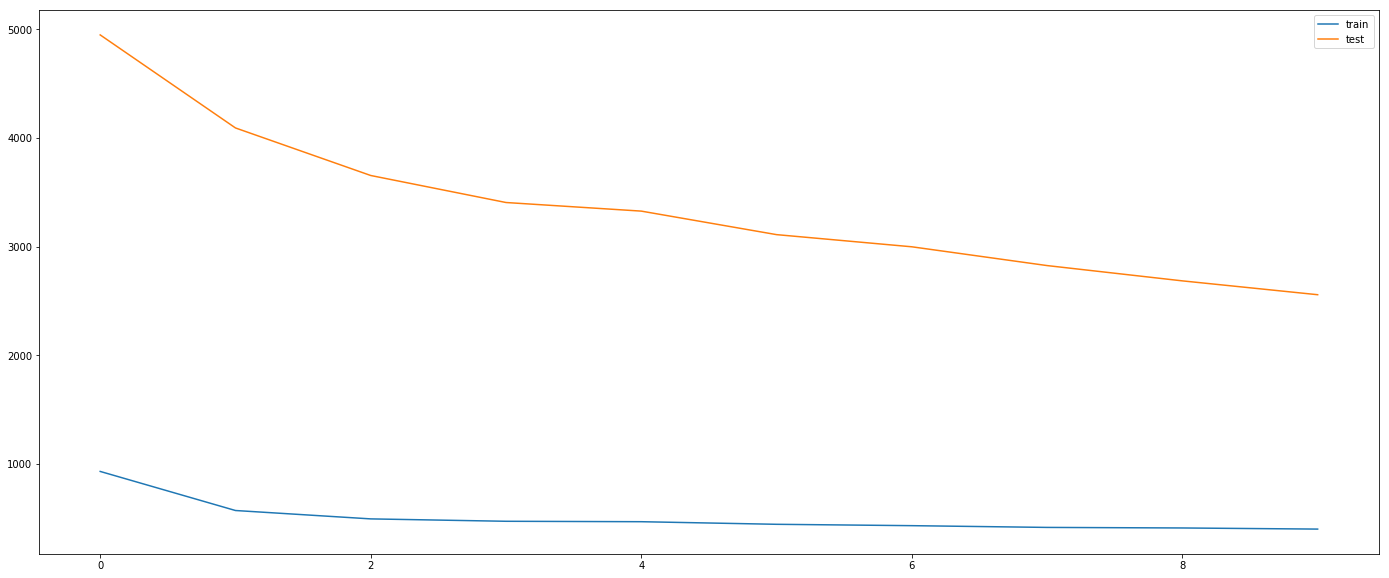

In [562]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig("2_lstm-training.png")
pyplot.show()


## 8. Prepare input data for prediction

In [563]:
test_data  = dev_count_perday['count'].to_numpy()[1005 - (360 + 205):] # 205 records were not part of training
print(len(test_data))
# ensure all data is float
test_data = test_data.astype('float32')

# normalize features
scaled = scaler.transform(test_data.reshape(-1, 1))
print(scaler.data_max_)
print(scaler.data_min_)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_input_seq, 1)
print(reframed.shape)
values = reframed.values

# split into input and outputs
n_obs = n_input_seq * n_features
test_X, test_y = values[:, :n_obs], values[:, n_obs:n_obs+n_features]
print(test_X.shape, len(test_X), test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], n_input_seq, n_features))
print(test_X.shape, test_y.shape)

565
[272.]
[1.]
<class 'numpy.ndarray'>
(205, 361)
(205, 360) 205 (205, 1)
(205, 360, 1) (205, 1)


In [564]:
values

array([[0.0295203 , 0.04059041, 0.08118082, ..., 0.22509226, 0.53505534,
        0.49446496],
       [0.04059041, 0.08118082, 0.11439115, ..., 0.53505534, 0.49446496,
        0.605166  ],
       [0.08118082, 0.11439115, 0.099631  , ..., 0.49446496, 0.605166  ,
        0.501845  ],
       ...,
       [0.18450186, 0.07380074, 0.08856089, ..., 0.44280443, 0.35793358,
        0.65682656],
       [0.07380074, 0.08856089, 0.19188192, ..., 0.35793358, 0.65682656,
        0.7785978 ],
       [0.08856089, 0.19188192, 0.2509225 , ..., 0.65682656, 0.7785978 ,
        0.8819188 ]], dtype=float32)

## 9. Prediction vs. Actual for the unseen data by the model (205 days)

In [579]:
model_file = "2_epoch-10_loss-399.9633_val_loss-2556.4310.h5"
    #model.compile(loss='mean_squared_error', optimizer="adam")
    #Test RMSE: 2362.879
    #epoch 10

#model_file = "epoch-211_loss-0.0380_val_loss-0.0798.h5"
    #Test RMSE: 80.059

K.clear_session()  # Clear previous models from memory.    
model = load_model(model_file)
# make a prediction
yhat = model.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# calculate RMSE
#rmse = sqrt(mean_squared_error(test_y, yhat))

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2362.879


default: [24.0, 10.0]


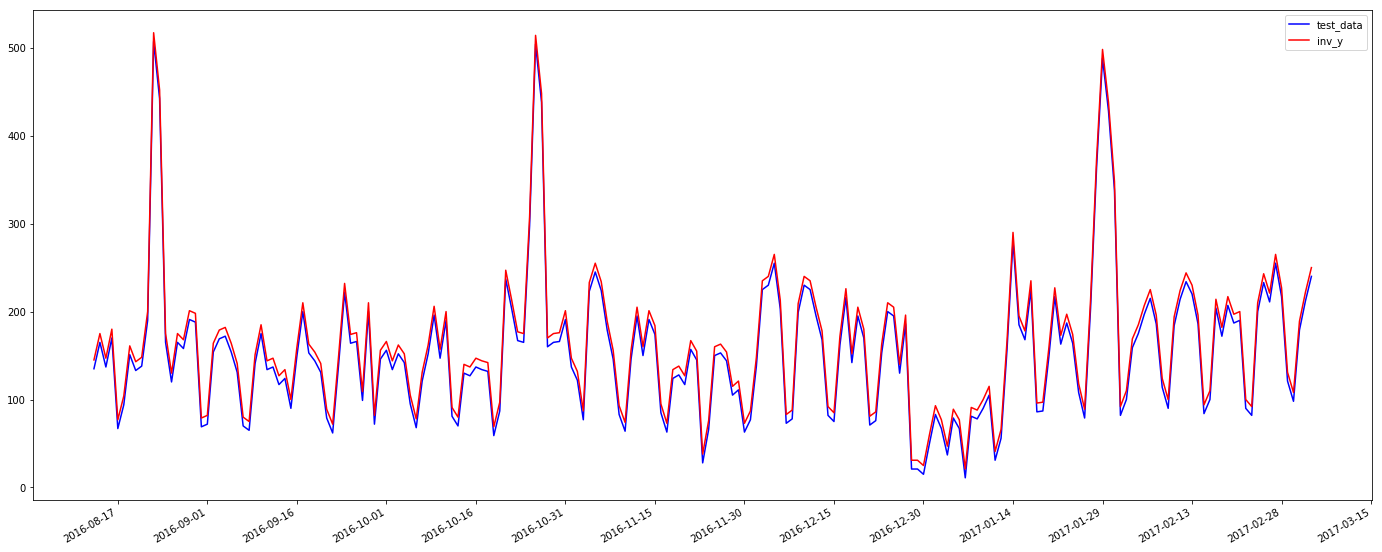

In [577]:
start = pd.Timestamp('2016-08-13')
end = start + timedelta(days=205)
days = mdates.drange(start, end,dt.timedelta(days=1))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

plt.plot(days, test_data[360:], "-b", label='test_data') # forecast
plt.plot(days, inv_y+10,    "-r"   , label='inv_y')   # actual

plt.legend(loc="upper right")
plt.gcf().autofmt_xdate()

fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 24
fig_size[1] = 10
plt.rcParams["figure.figsize"] =  fig_size 

plt.show()

default: [24.0, 10.0]


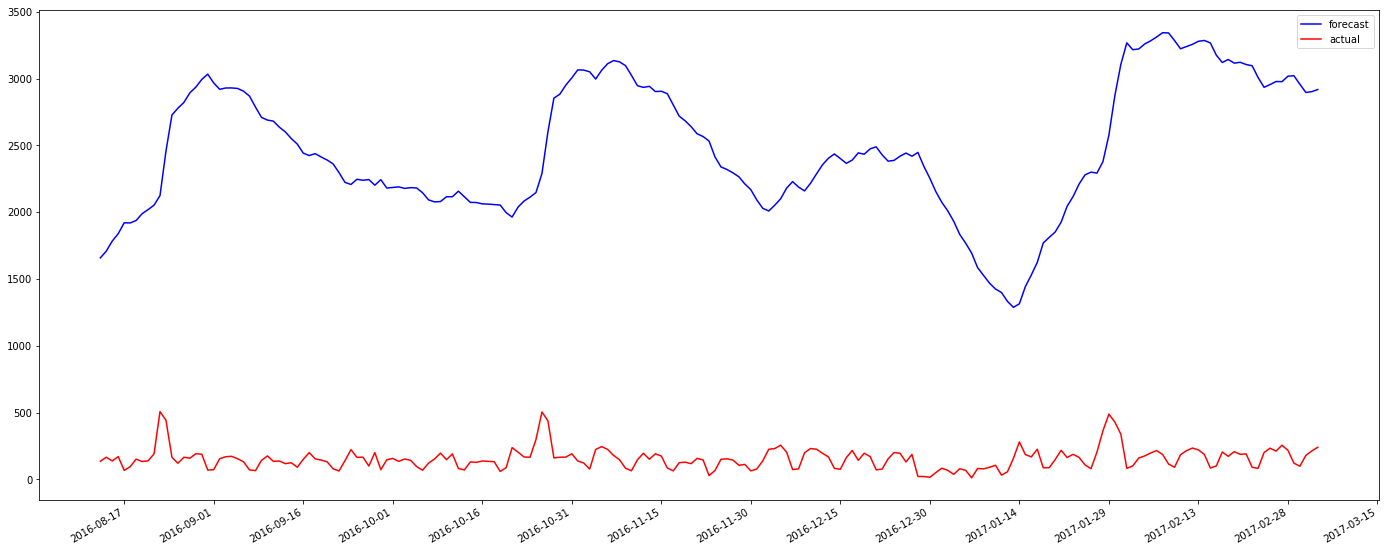

In [569]:
start = pd.Timestamp('2016-08-13')
end = start + timedelta(days=205)
days = mdates.drange(start, end,dt.timedelta(days=1))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

plt.plot(days, inv_yhat, "-b", label='forecast') # forecast
plt.plot(days, inv_y,    "-r"   , label='actual')   # actual

#plt.plot(days, yhat, "-b", label='forecast') # forecast
#plt.plot(days, test_y,    "-r"   , label='actual')   # actual


plt.legend(loc="upper right")
plt.gcf().autofmt_xdate()

fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 24
fig_size[1] = 10
plt.rcParams["figure.figsize"] =  fig_size 

plt.show()

In [568]:
inv_yhat.shape

(205, 1)

In [405]:
inv_y.shape

(205, 1)

## 10. Prediction for next year 

In [415]:
last_360days_data = pd.read_csv("prediction_input_data.csv", delimiter="," )
last_360days_data = last_360days_data["count"]
values = last_360days_data.values.astype('float32')

# normalize features
scaled = scaler.transform(values.reshape(-1, 1))
print(scaler.data_max_)
print(scaler.data_min_)


[272.]
[1.]


In [401]:
input_X = scaled.reshape(1,360,1)
input_X.shape

(1, 360, 1)

In [392]:
K.clear_session()  # Clear previous models from memory.    
model = load_model("epoch-211_loss-0.0380_val_loss-0.0798.h5")

In [411]:
next_year=list()

for i in range(1,361):
    # make a prediction
    #print("Predict %d day"%i)
    yhat = model.predict(input_X)

    # invert scaling for forecast
    inv_yhat = scaler.inverse_transform(yhat)
    next_year.append(inv_yhat[0][0])
    #print(inv_yhat[0][0], yhat[0][0])
    
    scaled = np.delete(scaled, 0)
    scaled = np.append(scaled, yhat[0][0])
    input_X = scaled.reshape(1,360,1)

Predict 1 day
Predict 2 day
Predict 3 day
Predict 4 day
Predict 5 day
Predict 6 day
Predict 7 day
Predict 8 day
Predict 9 day
Predict 10 day
Predict 11 day
Predict 12 day
Predict 13 day
Predict 14 day
Predict 15 day
Predict 16 day
Predict 17 day
Predict 18 day
Predict 19 day
Predict 20 day
Predict 21 day
Predict 22 day
Predict 23 day
Predict 24 day
Predict 25 day
Predict 26 day
Predict 27 day
Predict 28 day
Predict 29 day
Predict 30 day
Predict 31 day
Predict 32 day
Predict 33 day
Predict 34 day
Predict 35 day
Predict 36 day
Predict 37 day
Predict 38 day
Predict 39 day
Predict 40 day
Predict 41 day
Predict 42 day
Predict 43 day
Predict 44 day
Predict 45 day
Predict 46 day
Predict 47 day
Predict 48 day
Predict 49 day
Predict 50 day
Predict 51 day
Predict 52 day
Predict 53 day
Predict 54 day
Predict 55 day
Predict 56 day
Predict 57 day
Predict 58 day
Predict 59 day
Predict 60 day
Predict 61 day
Predict 62 day
Predict 63 day
Predict 64 day
Predict 65 day
Predict 66 day
Predict 67 day
Pred

In [412]:
#len(next_year)
#next_year

default: [24.0, 10.0]


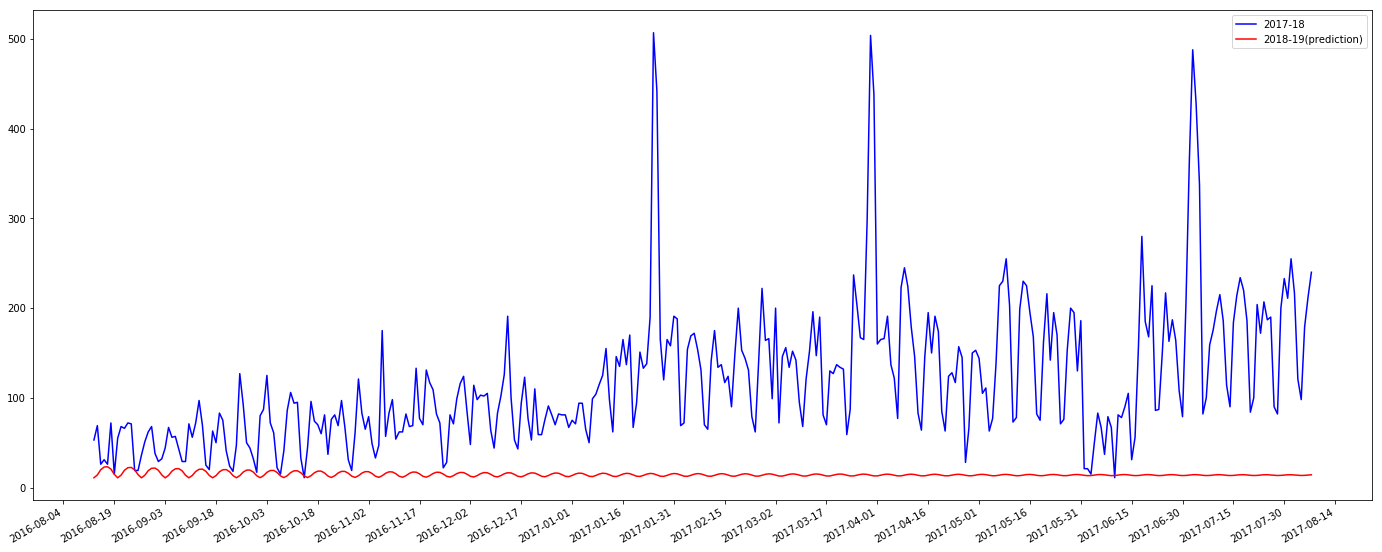

In [414]:
start = pd.Timestamp('2016-08-13')
end = start + timedelta(days=360)
days = mdates.drange(start, end,dt.timedelta(days=1))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

plt.plot(days, values, "-b", label='2017-18') # previous year
plt.plot(days, next_year,    "-r"   , label='2018-19(prediction)')   # forecast

plt.legend(loc="upper right")
plt.gcf().autofmt_xdate()

fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 24
fig_size[1] = 10
plt.rcParams["figure.figsize"] =  fig_size 

plt.show()